In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from astroquery.gaia import Gaia
import astropy

from astropy.coordinates import SkyCoord
from astropy import units
from sklearn.neighbors import NearestNeighbors

In [ ]:
def dens_profile(df):
    catalog = SkyCoord(ra=df['ra']*units.degree, dec=df['dec']*units.degree, frame='icrs')
    nstar = len(df)
    k = np.sqrt(nstar).astype(int)
    #.criando a estrutura de vizinhos proximos
    coords = np.array([df['ra']*np.cos(df['dec']*np.pi/180.0), df['dec']]).T
    nn_struct = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
    nn_struct.fit(coords)
    distances, index = nn_struct.kneighbors(coords)
    #.obtendo a distancia do k-esimo vizinho mais proximo
    aperture = distances[:,k-1]*units.degree
    area = np.pi*(aperture.value)**2# + area_cor(data, data.DEC, aperture.value)
    den_data = k/area
    den_sigm = np.sqrt(k)/area
    den_data /= 3600**2
    den_sigm /= 3600**2
    med_x = np.average(clip_loop['ra'], weights=den_data)
    med_y = np.average(clip_loop['dec'], weights=den_data)
    center = SkyCoord(med_x*units.degree, med_y*units.degree)
    radii = center.separation(catalog)
    radii = radii.to(units.arcsec).value
    return radii, den_data


In [3]:
import os
pastas = ['images','output_doitall', 'membros']
for element in pastas:
    try:
        os.mkdir(element)
    except: 
        break

In [4]:
#%matplotlib widget
%matplotlib inline

In [5]:
#from platform import python_version
#python_version()

In [6]:
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams['axes.linewidth'] = 1.0


font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)

## Getting the directory name

In [7]:
import os
directory_path = os.getcwd()
nome_aglo = directory_path.split('/')[-1]
nome_aglo

'FSR_1419'

## Getting RA&DEC from Bica 2019

In [8]:
df = pd.read_csv('../../Catalogues/aglomerados_projeto.txt', comment= '#')
ra, dec = df.loc[df['Nome'] == nome_aglo]['_RAJ2000'].values[0], df.loc[df['Nome'] == nome_aglo]['_DEJ2000'].values[0]

In [9]:
ra, dec

(124.725, -47.79222)

In [10]:
diam = df[df['Nome'] == nome_aglo].DIAM.iloc[0]
diam = diam*units.arcmin
diam = 1.5*diam.to(units.degree).value
diam

0.125

## Querying the data

In [11]:
tables = Gaia.load_tables(only_names=True)

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


In [12]:
meta = Gaia.load_table('gaiadr3.gaia_source')
meta

Retrieving table 'gaiadr3.gaia_source'


In [13]:
query = """SELECT 
source_id, ra, dec, pmra, pmra_error, pmdec, pmdec_error, bp_rp, phot_g_mean_mag, parallax, parallax_error, radial_velocity, radial_velocity_error, l,b,
ruwe, phot_g_n_obs, phot_bp_n_obs, phot_rp_n_obs
FROM gaiadr3.gaia_source
WHERE 1=CONTAINS(POINT('ICRS',ra,dec),
CIRCLE('ICRS', """ +  str(ra) + ',' + str(dec) + ',' +  str(diam) + ' ))'

In [14]:
job = Gaia.launch_job_async(query)
job

INFO: Query finished. [astroquery.utils.tap.core]


In [15]:
data = job.get_results()
len(data)

4783

## Converting to pandas

In [16]:
df = data.to_pandas()
df

,source_id,ra,dec,pmra,pmra_error,pmdec,pmdec_error,bp_rp,phot_g_mean_mag,parallax,parallax_error,radial_velocity,radial_velocity_error,l,b,ruwe,phot_g_n_obs,phot_bp_n_obs,phot_rp_n_obs
0,5516033889904354048,124.712731,-47.906897,-2.690392,0.078932,3.841236,0.082832,1.532091,17.670631,0.130311,0.074235,NaN,NaN,264.145614,-6.678374,0.967331,352,39,39
1,5516033133985594240,124.765802,-47.913603,-4.341626,1.894900,3.741732,1.874871,0.736521,20.819054,-4.685065,1.860324,NaN,NaN,264.171124,-6.652520,1.585829,140,10,16
2,5516033164045122048,124.742992,-47.914688,-1.790131,0.126479,2.948717,0.138990,1.400284,18.428986,0.221875,0.119870,NaN,NaN,264.163480,-6.665834,0.974351,348,34,35
3,5516033164053376256,124.745548,-47.910020,0.710261,0.169799,-0.105137,0.181005,2.136635,18.889185,0.034958,0.155847,NaN,NaN,264.160530,-6.661816,1.016019,390,37,40
4,5516033168345330944,124.747971,-47.911467,NaN,NaN,NaN,NaN,1.941893,21.101509,NaN,NaN,NaN,NaN,264.162650,-6.661269,NaN,61,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4778,5516056945288536320,124.698472,-47.682064,-9.026370,0.024175,8.163831,0.024648,1.050774,14.977345,0.684085,0.021290,NaN,NaN,263.952028,-6.561480,1.051489,344,41,41
4779,5516056945288537472,124.706671,-47.676042,-4.386987,0.018400,10.651087,0.018267,0.784358,14.356404,0.603464,0.016819,32.15448,10.190917,263.950074,-6.553545,1.078825,323,38,37
4780,5516057151446961024,124.689126,-47.670646,-2.132115,0.066424,2.128205,0.066501,1.415197,17.217230,0.426753,0.060878,NaN,NaN,263.938952,-6.560371,1.043875,327,37,35
4781,5516057422021241728,124.606254,-47.697281,-1.841484,0.176121,3.389486,0.183750,1.138622,18.963932,0.062191,0.154087,NaN,NaN,263.930092,-6.621564,1.022886,380,43,40


In [17]:
#import plotly.express as px

In [18]:
#fig = px.scatter(x = df.pmra_error, y = df.pmra)
#fig.show()

## Applying better conditions to the variables

In [19]:
condicao = np.abs(0.5*df.pmra) < df.pmra_error
condicao2 = np.abs(0.5*df.pmdec) < df.pmdec_error
condicao3 = np.abs(0.5*df.parallax) < df.parallax_error


df_condicionado = df.drop(df[condicao|condicao2|condicao3].index) #
len(df_condicionado),len(df)

(1882, 4783)

## Dropping uknown values of pmra, pmdec or parallax.

In [20]:
ndf = df_condicionado.dropna(how='any',subset=['pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'parallax', 'parallax_error','phot_g_mean_mag', 'bp_rp'])
ndf

,source_id,ra,dec,pmra,pmra_error,pmdec,pmdec_error,bp_rp,phot_g_mean_mag,parallax,parallax_error,radial_velocity,radial_velocity_error,l,b,ruwe,phot_g_n_obs,phot_bp_n_obs,phot_rp_n_obs
10,5516033202704880000,124.765802,-47.905533,-6.474311,0.856702,8.634940,0.789575,1.499563,20.540516,2.231455,0.716746,NaN,NaN,264.164370,-6.648035,1.020321,225,16,16
12,5516033202709571712,124.765443,-47.906956,0.578923,0.011284,2.590869,0.012490,0.839230,13.045532,0.665931,0.010569,14.413105,2.767144,264.165427,-6.649026,1.025527,403,44,43
13,5516033202709574144,124.758306,-47.907453,-2.202218,0.204462,3.148838,0.229361,1.443819,19.157505,0.431897,0.197072,NaN,NaN,264.163166,-6.653279,1.021805,368,36,36
15,5516033679441228928,124.671374,-47.910283,-2.653253,0.095845,4.233966,0.098179,1.405569,17.971231,0.175981,0.086883,NaN,NaN,264.132958,-6.703313,0.965142,389,44,42
20,5516033752465415936,124.660602,-47.899135,-5.084749,0.067373,6.435408,0.071919,1.477947,17.308092,0.285553,0.062002,NaN,NaN,264.119585,-6.703137,1.018882,364,41,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4762,5516057013995751168,124.741973,-47.669576,-1.699467,0.658662,5.299561,0.755069,1.544712,20.493292,1.718471,0.601906,NaN,NaN,263.957959,-6.530189,0.946019,231,23,26
4777,5516056945288535552,124.700136,-47.676836,-6.993425,0.037494,11.934457,0.040768,1.173304,16.066454,0.975154,0.034226,NaN,NaN,263.948279,-6.557645,1.033380,327,35,34
4778,5516056945288536320,124.698472,-47.682064,-9.026370,0.024175,8.163831,0.024648,1.050774,14.977345,0.684085,0.021290,NaN,NaN,263.952028,-6.561480,1.051489,344,41,41
4779,5516056945288537472,124.706671,-47.676042,-4.386987,0.018400,10.651087,0.018267,0.784358,14.356404,0.603464,0.016819,32.154480,10.190917,263.950074,-6.553545,1.078825,323,38,37


## Determining the background

In [22]:
#.Definicão da função de correção de area
#.(calcula a parte da area de um círculo que esta fora das bordas da imagem)
def area_cor( radata, dedata, ap ):

    cosd = np.cos(dedata*np.pi/180.0)
    rarg = [min(radata),max(radata)]
    derg = [min(dedata),max(dedata)]
    
    b = np.array([(rarg[1]-radata)*cosd, (radata-rarg[0])*cosd, ap])
    c = np.array([ derg[1]-dedata, dedata-derg[0], ap ])
    b = np.min(b,axis=0)  ;  c = np.min(c,axis=0)
    P = 0.5*np.pi*ap**2 - c*np.sqrt(ap**2-c**2) - np.arcsin(c/ap)*ap**2
    Q = 0.5*np.pi*ap**2 - b*np.sqrt(ap**2-b**2) - np.arcsin(b/ap)*ap**2
    O = 0.5*( -c*np.sqrt(ap**2-c**2) - b*np.sqrt(ap**2-b**2) + \
     np.arccos(c/ap)*ap**2 - np.arcsin(b/ap)*ap**2) + c*b
    O = O*(abs(b) < np.sqrt(ap**2-c**2))
    area_cor = -P -Q +O
    return area_cor

0.0019853296804525885


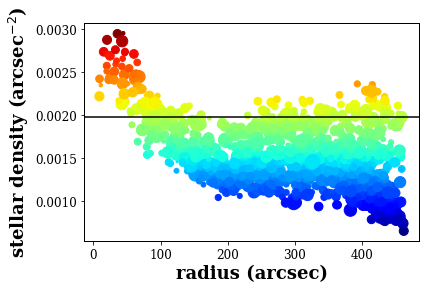

In [23]:
catalog = SkyCoord(ra=ndf['ra']*units.degree, dec=ndf['dec']*units.degree, frame='fk5')

nstar = len(ndf)

#.Definindo o vizinho apropriado para a abertura

k = np.sqrt(nstar).astype(int)

#.criando a estrutura de vizinhos proximos
coords = np.array([ndf['ra'], ndf['dec']]).T
nn_struct = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
nn_struct.fit(coords)
distances, index = nn_struct.kneighbors(coords)
             

#.obtendo a distancia do k-esimo vizinho mais proximo
aperture = distances[:,k-1]*units.degree
area = np.pi*(aperture.value)**2 + area_cor(ndf.ra, ndf.dec, aperture.value)
den_data = k/area
den_sigm = np.sqrt(k)/area

den_data /= 3600**2
den_sigm /= 3600**2

med_x = np.average(ndf['ra'], weights=den_data)
std_x = np.average((ndf['ra']-med_x)**2, weights=den_data)**0.5

med_y = np.average(ndf['dec'], weights=den_data)
std_y = np.average((ndf['dec']-med_y)**2, weights=den_data)**0.5

center = SkyCoord(med_x*units.degree, med_y*units.degree)
radii = center.separation(catalog)
radii = radii.to(units.arcsec).value

#.criando figura do RDP

import matplotlib.cm as cm
cor = cm.get_cmap('jet')

fig, ax = plt.subplots()#1,1,figsize=(10,11))
ax.scatter(radii,den_data, s=(max(ndf['phot_g_mean_mag'])-ndf['phot_g_mean_mag'])*20, c=den_data/3600**2, cmap = cor, label='data')
ax.set_xlabel('radius (arcsec)', fontsize=18, fontweight='bold')
ax.set_ylabel('stellar density (arcsec$^{-2}$)', fontsize=18, fontweight='bold')


norm_den = den_data/np.max(den_data)
bg_select = (norm_den > 0.65) & (norm_den < 0.7)
med_bg = np.median(den_data[bg_select])
std_bg = 0.5*med_bg

ax.axhline(med_bg, color = 'k')
print(med_bg)



In [24]:
raio_max = np.max(radii)*units.arcsec
raio_max = raio_max.to(units.radian).value
dens = med_bg
dens = dens*(1/units.arcsec*(1/units.arcsec))
dens = dens.to(1/units.sr).value
estrelas = len(df_condicionado) - dens*np.pi*raio_max**2
estrelas

552.0663724454239

## Creating the arrays to perform the 5-D HDBSCAN fit

In [188]:
cincoD = np.array((ndf['pmra'],ndf['pmdec'],ndf['ra'],ndf['dec'],ndf['parallax'])).T
tresD = np.array((ndf['pmra'],ndf['pmdec'],ndf['parallax'])).T

vapo = np.array((ndf.ra,ndf.dec)).T

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

rs_5d = RobustScaler().fit_transform(cincoD)
sc_5d = StandardScaler().fit_transform(cincoD)
mm_5d = MinMaxScaler().fit_transform(cincoD)

## Performing the HDBSCAN

In [27]:
import hdbscan

Estimated no. of clusters: 1
Estimated no. of noise points: 1186
Estimated no. points clustered: 200


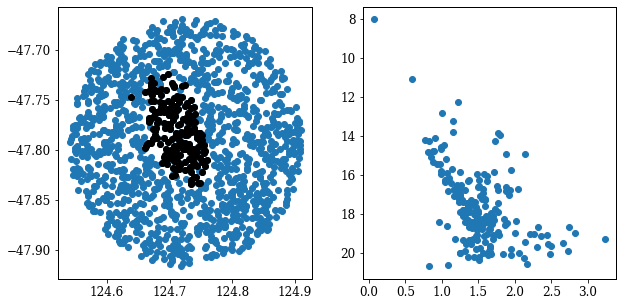

In [189]:
ui = StandardScaler().fit_transform(vapo)
clusterer = hdbscan.HDBSCAN(min_cluster_size = 200, min_samples = 200,  allow_single_cluster=True, cluster_selection_method = 'eom', metric = 'euclidean').fit(vapo)


labels = clusterer.labels_


ndf = ndf.assign(labels=labels)
ndf = ndf.assign(prob=clusterer.probabilities_)


N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

n_noise = list(clusterer.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

n_in = list(clusterer.labels_).count(0)
print('Estimated no. points clustered: %d' % n_in)

subset = ndf[ndf.labels == 0]


fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(subset.ra,subset.dec, color = 'k', zorder = 100)
ax[0].scatter(ndf.ra,ndf.dec)


ax[1].scatter(subset['bp_rp'],subset['phot_g_mean_mag'])
ax[1].invert_yaxis()


Estimated no. of clusters: 1
Estimated no. of noise points: 1186
Estimated no. points clustered: 200


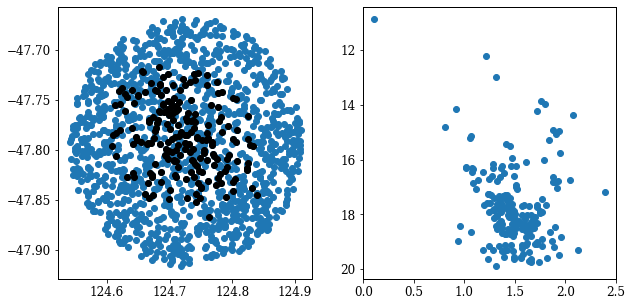

In [187]:
pts_expected = int(estrelas)

clusterer = hdbscan.HDBSCAN(min_cluster_size = 200, min_samples = 200,  allow_single_cluster=True, cluster_selection_method = 'eom', metric = 'euclidean').fit(sc_5d)


labels = clusterer.labels_


ndf = ndf.assign(labels=labels)
ndf = ndf.assign(prob=clusterer.probabilities_)


N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

n_noise = list(clusterer.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

n_in = list(clusterer.labels_).count(0)
print('Estimated no. points clustered: %d' % n_in)

subset = ndf[ndf.labels == 0]


fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(subset.ra,subset.dec, color = 'k', zorder = 100)
ax[0].scatter(ndf.ra,ndf.dec)


ax[1].scatter(subset['bp_rp'],subset['phot_g_mean_mag'])
ax[1].invert_yaxis()


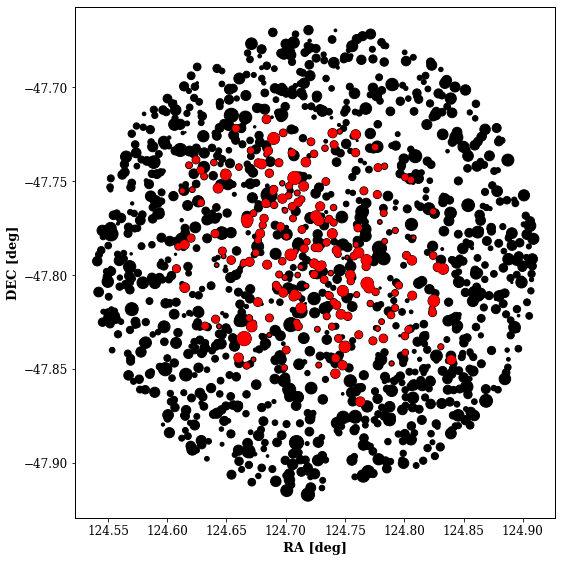

In [157]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(subset.ra,subset.dec,  s=(max(subset['phot_g_mean_mag'])-subset['phot_g_mean_mag'])*20, color = 'red', zorder = 100)
ax.scatter(ndf.ra,ndf.dec,  s=(max(ndf['phot_g_mean_mag'])-ndf['phot_g_mean_mag'])*20, color = 'k')
ax.set_xlabel('RA [deg]', fontweight = 'bold')
ax.set_ylabel('DEC [deg]', fontweight = 'bold')
plt.tight_layout()


## Parameters

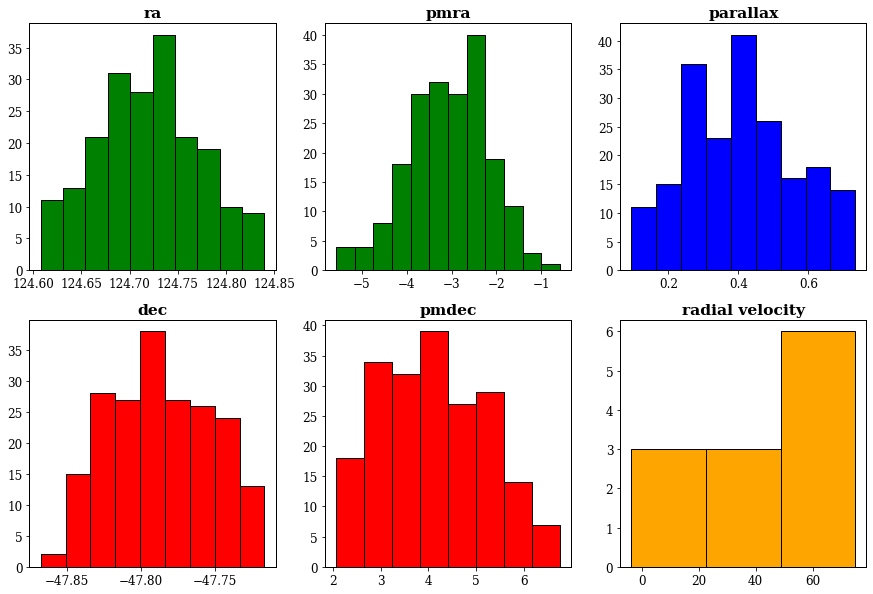

In [158]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

optimal_bin = np.histogram_bin_edges(subset['ra'], bins = 'fd')
ax[0,0].hist(subset['ra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(subset['pmra'], bins = 'fd')
ax[0,1].hist(subset['pmra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(subset['dec'], bins = 'fd')
ax[1,0].hist(subset['dec'], optimal_bin,  ec = 'k', color = 'red');

optimal_bin = np.histogram_bin_edges(subset['pmdec'], bins = 'fd')
ax[1,1].hist(subset['pmdec'], optimal_bin,  ec = 'k', color = 'red');


optimal_bin = np.histogram_bin_edges(subset['parallax'], bins = 'fd')
ax[0,2].hist(subset['parallax'], optimal_bin, ec = 'k',color = 'blue');

ra_vel = subset.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')
ax[1,2].hist(ra_vel.radial_velocity, optimal_bin, ec = 'k',color = 'orange');


ax[0,0].set_title('ra', fontweight = 'bold')
ax[0,1].set_title('pmra', fontweight = 'bold')
ax[1,0].set_title('dec', fontweight = 'bold')
ax[1,1].set_title('pmdec', fontweight = 'bold')
ax[0,2].set_title('parallax', fontweight = 'bold')
ax[1,2].set_title('radial velocity', fontweight = 'bold');

## Gaussian fit

In [159]:
def gaussiana(x, amp, mu, sigma):
    return amp*np.exp(-(x-mu)**2/(2*sigma**2))

from lmfit.models import GaussianModel

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 9
    # variables        = 3
    chi-square         = 341.673893
    reduced chi-square = 56.9456489
    Akaike info crit   = 38.7296896
    Bayesian info crit = 39.3213633
[[Variables]]
    amplitude:  17.5364383 +/- 2.68109747 (15.29%) (init = 9.586201)
    center:     0.39180817 +/- 0.03475730 (8.87%) (init = 0.4141281)
    sigma:      0.21491878 +/- 0.04191817 (19.50%) (init = 0.1065133)
    fwhm:       0.50609505 +/- 0.09870974 (19.50%) == '2.3548200*sigma'
    height:     32.5519572 +/- 4.47148501 (13.74%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.713


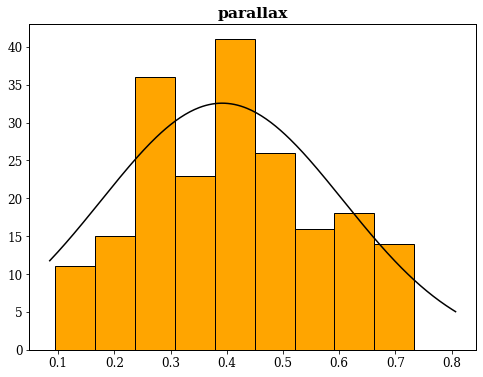

In [160]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['parallax']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'orange');

numero, bins = histograma[0], histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(0.9*bins[0],1.1*bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('parallax', fontweight = 'bold')

plt.show()

In [161]:
#gmodel = GaussianModel(independent_vars = ['x', 'center'])
#inicial = gmodel.guess(numero, x = teste, center = 0.4)
#result = gmodel.fit(numero, inicial, x=teste, center = 0.4)
#print(result.fit_report())


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 10
    # variables        = 3
    chi-square         = 102.349749
    reduced chi-square = 14.6213927
    Akaike info crit   = 29.2581076
    Bayesian info crit = 30.1658629
[[Variables]]
    amplitude:  5.42620949 +/- 0.39783892 (7.33%) (init = 2.164453)
    center:     124.717144 +/- 0.00549347 (0.00%) (init = 124.7109)
    sigma:      0.06773386 +/- 0.00611636 (9.03%) (init = 0.0257673)
    fwhm:       0.15950106 +/- 0.01440293 (9.03%) == '2.3548200*sigma'
    height:     31.9595597 +/- 2.23808933 (7.00%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.651


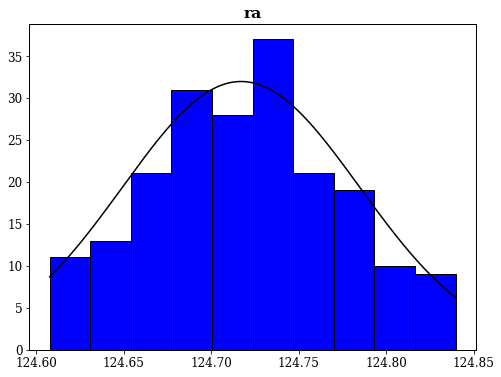

In [162]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['ra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'blue');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_ra = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('ra', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 12
    # variables        = 3
    chi-square         = 161.749529
    reduced chi-square = 17.9721698
    Akaike info crit   = 37.2137084
    Bayesian info crit = 38.6684284
[[Variables]]
    amplitude:  91.6120622 +/- 6.63403685 (7.24%) (init = 79.56214)
    center:    -2.99214659 +/- 0.08419250 (2.81%) (init = -3.081664)
    sigma:      1.00918589 +/- 0.08476493 (8.40%) (init = 0.6800183)
    fwhm:       2.37645112 +/- 0.19960616 (8.40%) == '2.3548200*sigma'
    height:     36.2152574 +/- 2.61910392 (7.23%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.581


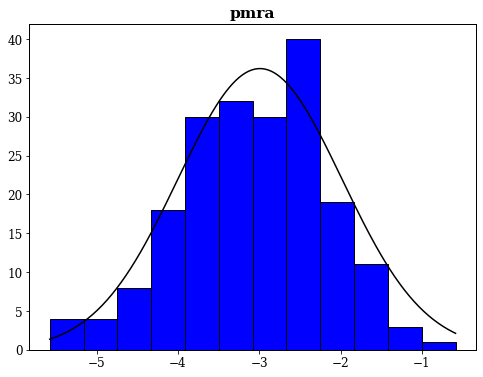

In [163]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['pmra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'blue');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_pmra= [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('pmra', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 9
    # variables        = 3
    chi-square         = 148.756698
    reduced chi-square = 24.7927829
    Akaike info crit   = 31.2457874
    Bayesian info crit = 31.8374612
[[Variables]]
    amplitude:  4.14752361 +/- 0.40067996 (9.66%) (init = 5.078129)
    center:    -47.7855498 +/- 0.00507570 (0.01%) (init = -47.78275)
    sigma:      0.04898712 +/- 0.00598758 (12.22%) (init = 0.04701971)
    fwhm:       0.11535586 +/- 0.01409968 (12.22%) == '2.3548200*sigma'
    height:     33.7766850 +/- 2.97939660 (8.82%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.698


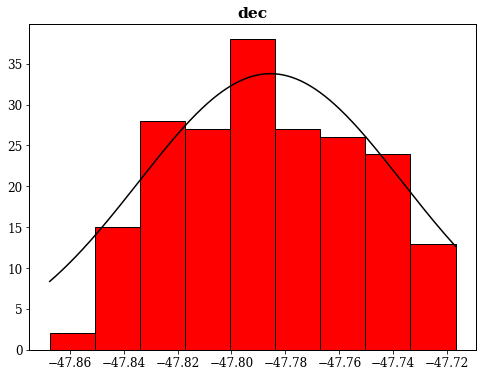

In [164]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['dec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'red');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_dec = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('dec', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 8
    # variables        = 3
    chi-square         = 101.050215
    reduced chi-square = 20.2100429
    Akaike info crit   = 26.2894082
    Bayesian info crit = 26.5277328
[[Variables]]
    amplitude:  153.303956 +/- 14.1003343 (9.20%) (init = 128.4289)
    center:     3.86012351 +/- 0.16074887 (4.16%) (init = 4.072587)
    sigma:      1.66463949 +/- 0.19558599 (11.75%) (init = 1.337801)
    fwhm:       3.91992637 +/- 0.46056981 (11.75%) == '2.3548200*sigma'
    height:     36.7403470 +/- 2.79464972 (7.61%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.762
    C(center, sigma)     = -0.290
    C(amplitude, center) = -0.269


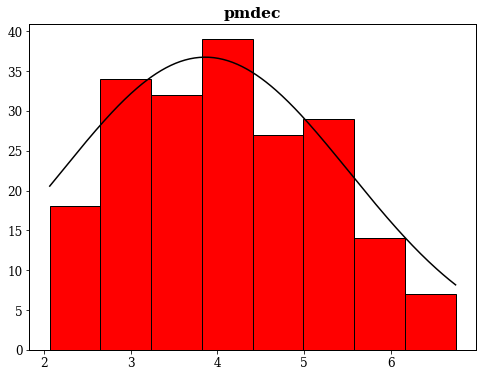

In [165]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['pmdec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'red');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_pmdec = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('pmdec', fontweight = 'bold')

plt.show()

## Sigma Clipping

In [166]:
gmodel = GaussianModel()
clip_loop = subset

for i in range(3):
    print(len(clip_loop))
    data = clip_loop['ra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_ra = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmra = [result.params['center'].value, result.params['sigma'].value]
    
    data = clip_loop['dec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_dec = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmdec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmdec = [result.params['center'].value, result.params['sigma'].value]


    data = clip_loop['parallax']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]


    sigma = 2

    paralaxe_up, paralaxe_down = valores_paralaxe[0] + sigma*valores_paralaxe[1], valores_paralaxe[0] - sigma*valores_paralaxe[1]
    ra_up, ra_down = valores_ra[0] + sigma*valores_ra[1], valores_ra[0] - sigma*valores_ra[1]
    pmra_up, pmra_down = valores_pmra[0] + sigma*valores_pmra[1], valores_pmra[0] - sigma*valores_pmra[1]
    dec_up, dec_down = valores_dec[0] + sigma*valores_dec[1], valores_dec[0] - sigma*valores_dec[1]
    pmdec_up, pmdec_down = valores_pmdec[0] + sigma*valores_pmdec[1], valores_pmdec[0] - sigma*valores_pmdec[1]
    #radvel_up, radvel_down = valores_radial_velocity[0] + sigma*valores_radial_velocity[1], valores_radial_velocity[0] - sigma*valores_radial_velocity[1]
    clip_loop = clip_loop.loc[(clip_loop.parallax < paralaxe_up ) & (clip_loop.parallax > paralaxe_down) & (clip_loop.ra>ra_down) & (clip_loop.ra<ra_up) & 
                              (clip_loop.dec>dec_down) & (clip_loop.dec<dec_up) & (clip_loop.pmra>pmra_down) & (clip_loop.pmra<pmra_up) & (clip_loop.pmdec>pmdec_down) 
                              & (clip_loop.pmdec<pmdec_up)]# & (clip_loop.radial_velocity.isnull() | (clip_loop.radial_velocity>radvel_down) & (clip_loop.radial_velocity<radvel_up)) ]

    
print(len(clip_loop))


200
192
192
192


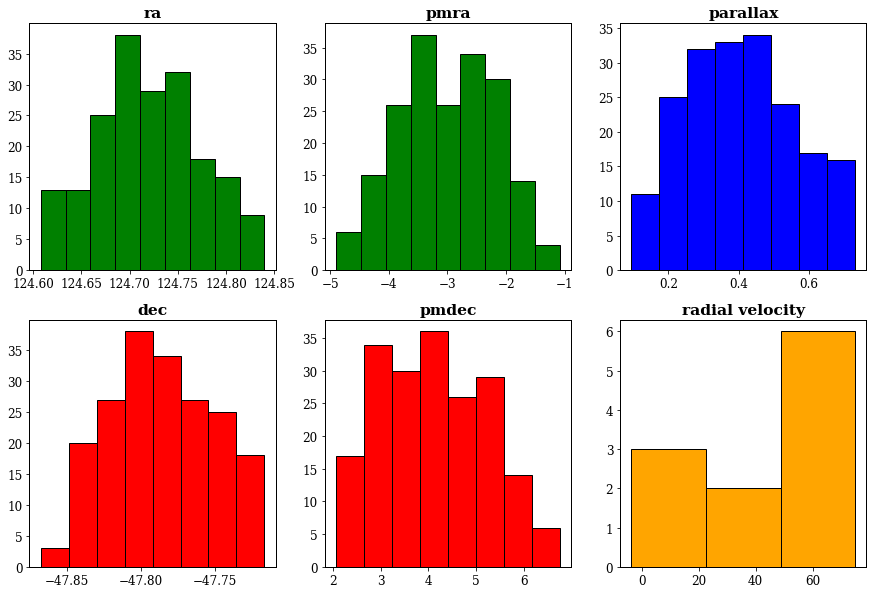

In [167]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

optimal_bin = np.histogram_bin_edges(clip_loop['ra'], bins = 'fd')
ax[0,0].hist(clip_loop['ra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(clip_loop['pmra'], bins = 'fd')
ax[0,1].hist(clip_loop['pmra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(clip_loop['dec'], bins = 'fd')
ax[1,0].hist(clip_loop['dec'], optimal_bin,  ec = 'k', color = 'red');

optimal_bin = np.histogram_bin_edges(clip_loop['pmdec'], bins = 'fd')
ax[1,1].hist(clip_loop['pmdec'], optimal_bin,  ec = 'k', color = 'red');


optimal_bin = np.histogram_bin_edges(clip_loop['parallax'], bins = 'fd')
ax[0,2].hist(clip_loop['parallax'], optimal_bin, ec = 'k',color = 'blue');

ra_vel = clip_loop.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')
ax[1,2].hist(ra_vel.radial_velocity, optimal_bin, ec = 'k',color = 'orange');


ax[0,0].set_title('ra', fontweight = 'bold')
ax[0,1].set_title('pmra', fontweight = 'bold')
ax[1,0].set_title('dec', fontweight = 'bold')
ax[1,1].set_title('pmdec', fontweight = 'bold')
ax[0,2].set_title('parallax', fontweight = 'bold')
ax[1,2].set_title('radial velocity', fontweight = 'bold');

## FINAL RESULTS

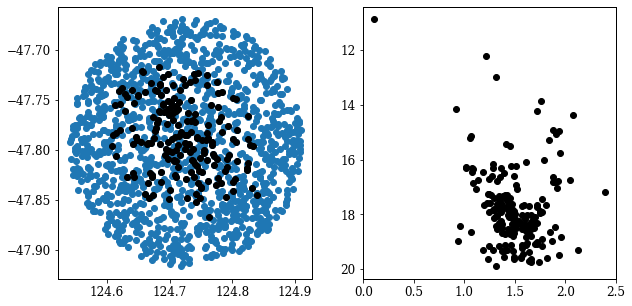

In [168]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(clip_loop.ra,clip_loop.dec, color = 'k', zorder = 100)
ax[0].scatter(ndf.ra,ndf.dec)


ax[1].scatter(clip_loop['bp_rp'],clip_loop['phot_g_mean_mag'], color = 'k')
ax[1].invert_yaxis()

In [169]:
from astropy.coordinates import Distance

teste =  Distance(parallax=clip_loop['parallax'].to_numpy()*units.mas)

np.min(teste), np.max(teste)

(<Distance 1364.94410995 pc>, <Distance 10572.158291 pc>)

In [170]:
clip_loop.to_csv('membros/final_5d.csv', index=False)

In [171]:
for i in range(1):
    print(len(clip_loop))
    data = clip_loop['ra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_ra = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmra = [result.params['center'].value, result.params['sigma'].value]
    
    data = clip_loop['dec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_dec = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmdec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmdec = [result.params['center'].value, result.params['sigma'].value]


    data = clip_loop['parallax']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]


192


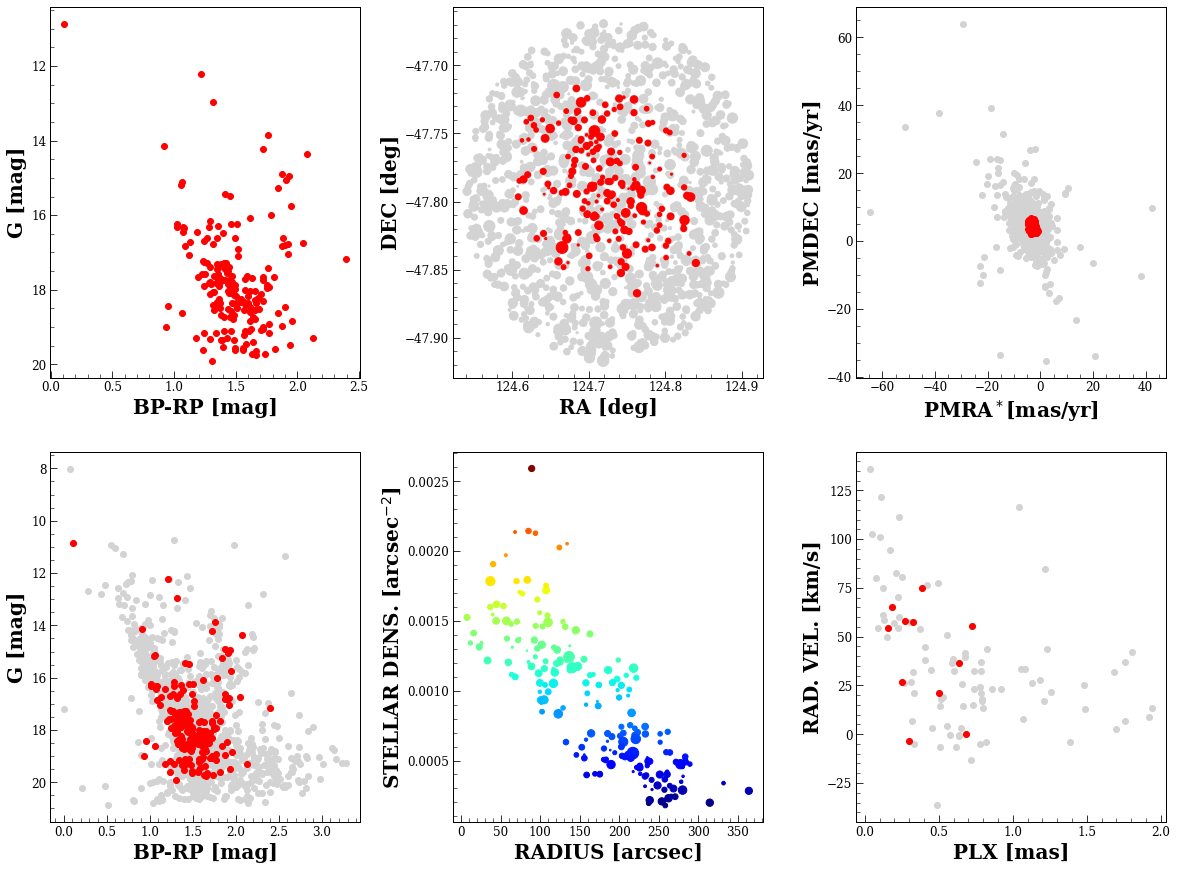

In [172]:
fig = plt.figure(figsize = (20,15))

ax1 = fig.add_subplot(2,3, (1,1))
ax2 = fig.add_subplot(2,3, (2,2))
ax3 = fig.add_subplot(2,3, (3,3))
ax4 = fig.add_subplot(2,3, (5,5))
ax5 = fig.add_subplot(2,3, (6,6))
ax6 = fig.add_subplot(2,3,(4,4))



ax6.scatter(clip_loop.bp_rp, clip_loop.phot_g_mean_mag, color = 'red', zorder = 100)
ax6.scatter(ndf.bp_rp, ndf.phot_g_mean_mag, color = 'lightgray')
ax6.invert_yaxis()
ax6.set_xlabel('BP-RP [mag]', fontweight = 'bold', fontsize = 20)
ax6.set_ylabel('G [mag]', fontweight = 'bold', fontsize = 20)

ax1.scatter(clip_loop.bp_rp, clip_loop.phot_g_mean_mag, color = 'red')
ax1.invert_yaxis()
ax1.set_xlabel('BP-RP [mag]', fontweight = 'bold', fontsize = 20)
ax1.set_ylabel('G [mag]', fontweight = 'bold', fontsize = 20)

ax2.scatter(clip_loop.ra, clip_loop.dec, color = 'red', s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*15, zorder = 1010)
ax2.scatter(ndf.ra, ndf.dec, color = 'lightgray', s=(max(ndf['phot_g_mean_mag'])-ndf['phot_g_mean_mag'])*15)
ax2.set_xlabel('RA [deg]', fontweight = 'bold', fontsize = 20)
ax2.set_ylabel('DEC [deg]', fontweight = 'bold', fontsize = 20)


ax3.scatter(clip_loop.pmra, clip_loop.pmdec, color = 'red', zorder= 100)
ax3.scatter(ndf.pmra, ndf.pmdec, color = 'lightgray')
ax3.set_xlabel('PMRA$^*$[mas/yr]', fontweight = 'bold', fontsize = 20)
ax3.set_ylabel('PMDEC [mas/yr]', fontweight = 'bold',fontsize = 20)


ra_vel_ndf = ndf.dropna(how='any',subset=['radial_velocity'])
ra_vel_ndf = ra_vel_ndf.loc[ra_vel_ndf.parallax <2]

ax5.scatter(ra_vel.parallax, ra_vel.radial_velocity, color = 'red', zorder= 100)
ax5.scatter(ra_vel_ndf.parallax, ra_vel_ndf.radial_velocity, color = 'lightgray')
ax5.set_xlabel('PLX [mas]', fontweight = 'bold',fontsize = 20)
ax5.set_ylabel('RAD. VEL. [km/s]', fontweight = 'bold',fontsize = 20)



radii, den_data = dens_profile(clip_loop)

import matplotlib.cm as cm
cor = cm.get_cmap('jet')


ax4.scatter(radii,den_data, s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*15, c=den_data/3600**2, cmap = cor)
ax4.set_xlabel('RADIUS [arcsec]', fontweight='bold', fontsize = 20)
ax4.set_ylabel('STELLAR DENS. [arcsec$^{-2}$]', fontweight='bold',fontsize = 20)


axs = [ax1,ax2,ax3,ax4,ax5,ax6]

for element in axs:
    element.xaxis.set_minor_locator(AutoMinorLocator())
    element.yaxis.set_minor_locator(AutoMinorLocator())
    element.tick_params(which = 'major', axis = 'y', direction='in', length = 7)
    element.tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
    element.tick_params(which = 'major', axis = 'x', direction='in', length = 7)
    element.tick_params(which = 'minor', axis = 'x', direction='in', length = 4)
    
plt.subplots_adjust(wspace = 0.3)
plt.show()



## Sigma Clipping Only VPD and plx

In [173]:
gmodel = GaussianModel()
clip_loop = subset


print(len(clip_loop))

j = 1

for i in range(j):
    data = clip_loop['pmra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmra = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmdec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmdec = [result.params['center'].value, result.params['sigma'].value]
    
    sigma = 1

    pmra_up, pmra_down = valores_pmra[0] + sigma*valores_pmra[1], valores_pmra[0] - sigma*valores_pmra[1]

    pmdec_up, pmdec_down = valores_pmdec[0] + sigma*valores_pmdec[1], valores_pmdec[0] - sigma*valores_pmdec[1]

    clip_loop = clip_loop.loc[(clip_loop.pmra>pmra_down) & (clip_loop.pmra<pmra_up) & (clip_loop.pmdec>pmdec_down) 
                              & (clip_loop.pmdec<pmdec_up)]

    
print(len(clip_loop))

gmodel = GaussianModel()

for i in range(1):

    data = clip_loop['parallax']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]


    sigma = 1

    paralaxe_up, paralaxe_down = valores_paralaxe[0] + sigma*valores_paralaxe[1], valores_paralaxe[0] - sigma*valores_paralaxe[1]
    clip_loop = clip_loop.loc[(clip_loop.parallax < paralaxe_up ) & (clip_loop.parallax > paralaxe_down)]



for i in range(0):
    ra_vel = clip_loop.dropna(how='any',subset=['radial_velocity'])
    data = ra_vel['radial_velocity']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_radial_velocity = [result.params['center'].value, result.params['sigma'].value]
    
    sigma = 2
    
    radvel_up, radvel_down = valores_radial_velocity[0] + sigma*valores_radial_velocity[1], valores_radial_velocity[0] - sigma*valores_radial_velocity[1]
    clip_loop = clip_loop.loc[(clip_loop.radial_velocity.isnull() | (clip_loop.radial_velocity>radvel_down) & (clip_loop.radial_velocity<radvel_up)) ]

ra_vel = clip_loop.dropna(how='any',subset=['radial_velocity'])
print(len(clip_loop))




200
132
113


In [174]:
clip_loop.to_csv('membros/final_semradec.csv', index = False)

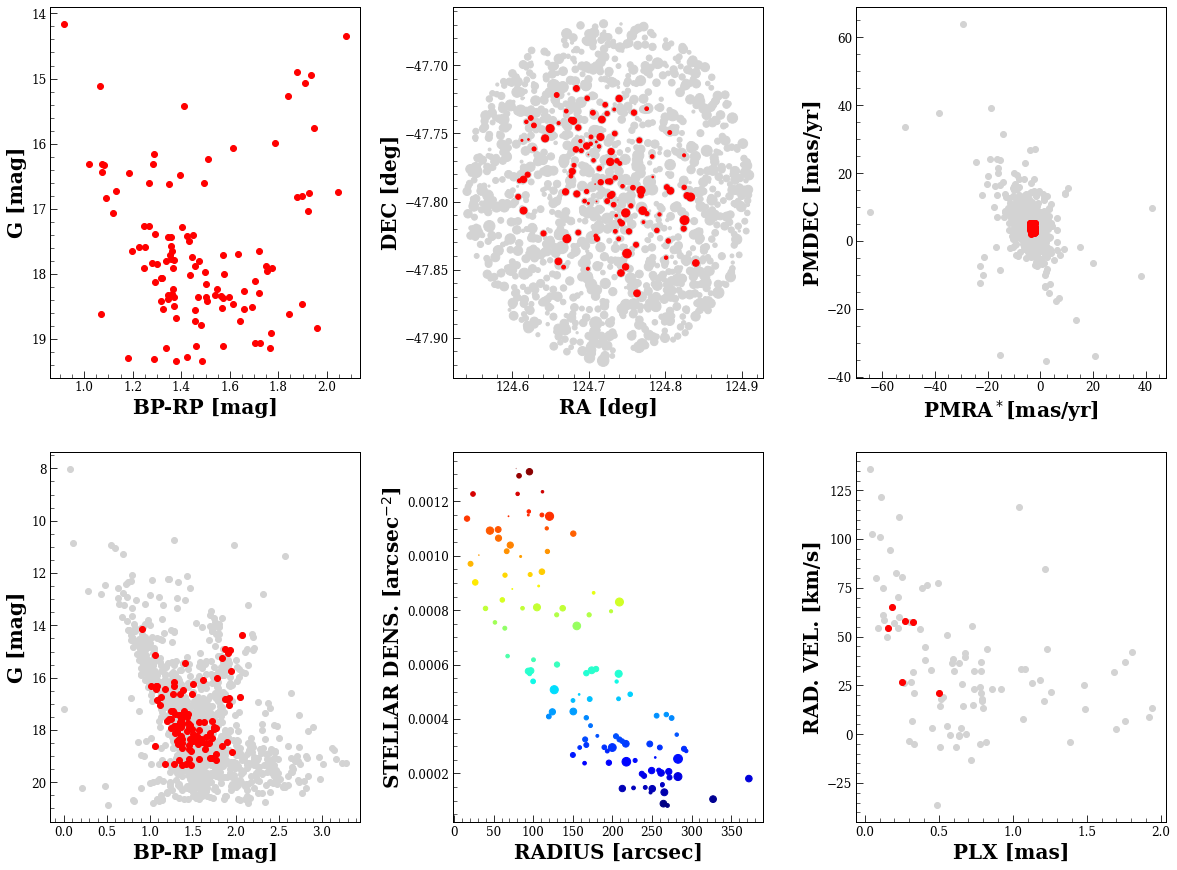

In [175]:
fig = plt.figure(figsize = (20,15))

ax1 = fig.add_subplot(2,3, (1,1))
ax2 = fig.add_subplot(2,3, (2,2))
ax3 = fig.add_subplot(2,3, (3,3))
ax4 = fig.add_subplot(2,3, (5,5))
ax5 = fig.add_subplot(2,3, (6,6))
ax6 = fig.add_subplot(2,3,(4,4))



ax6.scatter(clip_loop.bp_rp, clip_loop.phot_g_mean_mag, color = 'red', zorder = 100)
ax6.scatter(ndf.bp_rp, ndf.phot_g_mean_mag, color = 'lightgray')
ax6.invert_yaxis()
ax6.set_xlabel('BP-RP [mag]', fontweight = 'bold', fontsize = 20)
ax6.set_ylabel('G [mag]', fontweight = 'bold', fontsize = 20)

ax1.scatter(clip_loop.bp_rp, clip_loop.phot_g_mean_mag, color = 'red')
ax1.invert_yaxis()
ax1.set_xlabel('BP-RP [mag]', fontweight = 'bold', fontsize = 20)
ax1.set_ylabel('G [mag]', fontweight = 'bold', fontsize = 20)

ax2.scatter(clip_loop.ra, clip_loop.dec, color = 'red', s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*15, zorder = 1010)
ax2.scatter(ndf.ra, ndf.dec, color = 'lightgray', s=(max(ndf['phot_g_mean_mag'])-ndf['phot_g_mean_mag'])*15)
ax2.set_xlabel('RA [deg]', fontweight = 'bold', fontsize = 20)
ax2.set_ylabel('DEC [deg]', fontweight = 'bold', fontsize = 20)


ax3.scatter(clip_loop.pmra, clip_loop.pmdec, color = 'red', zorder= 100)
ax3.scatter(ndf.pmra, ndf.pmdec, color = 'lightgray')
ax3.set_xlabel('PMRA$^*$[mas/yr]', fontweight = 'bold', fontsize = 20)
ax3.set_ylabel('PMDEC [mas/yr]', fontweight = 'bold',fontsize = 20)


ra_vel_ndf = ndf.dropna(how='any',subset=['radial_velocity'])
ra_vel_ndf = ra_vel_ndf.loc[ra_vel_ndf.parallax <2]

ax5.scatter(ra_vel.parallax, ra_vel.radial_velocity, color = 'red', zorder= 100)
ax5.scatter(ra_vel_ndf.parallax, ra_vel_ndf.radial_velocity, color = 'lightgray')
ax5.set_xlabel('PLX [mas]', fontweight = 'bold',fontsize = 20)
ax5.set_ylabel('RAD. VEL. [km/s]', fontweight = 'bold',fontsize = 20)



radii, den_data = dens_profile(clip_loop)

import matplotlib.cm as cm
cor = cm.get_cmap('jet')


ax4.scatter(radii,den_data, s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*15, c=den_data/3600**2, cmap = cor)
ax4.set_xlabel('RADIUS [arcsec]', fontweight='bold', fontsize = 20)
ax4.set_ylabel('STELLAR DENS. [arcsec$^{-2}$]', fontweight='bold',fontsize = 20)


axs = [ax1,ax2,ax3,ax4,ax5,ax6]

for element in axs:
    element.xaxis.set_minor_locator(AutoMinorLocator())
    element.yaxis.set_minor_locator(AutoMinorLocator())
    element.tick_params(which = 'major', axis = 'y', direction='in', length = 7)
    element.tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
    element.tick_params(which = 'major', axis = 'x', direction='in', length = 7)
    element.tick_params(which = 'minor', axis = 'x', direction='in', length = 4)
    
plt.subplots_adjust(wspace = 0.3)
plt.show()



In [176]:
for i in range(1):
    print(len(clip_loop))
    data = clip_loop['ra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_ra = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmra = [result.params['center'].value, result.params['sigma'].value]
    
    data = clip_loop['dec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_dec = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmdec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmdec = [result.params['center'].value, result.params['sigma'].value]


    data = clip_loop['parallax']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]


113


## Clipping redondo

In [182]:
gmodel = GaussianModel()

data = subset['pmra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
numero, bins = np.histogram(data, optimal_bin)
teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
inicial = gmodel.guess(numero, x = teste)
result = gmodel.fit(numero, inicial, x=teste)
valores_pmra = [result.params['center'].value, result.params['sigma'].value]

gmodel = GaussianModel()

data = subset['pmdec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
numero, bins = np.histogram(data, optimal_bin)
teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
inicial = gmodel.guess(numero, x = teste)
result = gmodel.fit(numero, inicial, x=teste)
valores_pmdec = [result.params['center'].value, result.params['sigma'].value]

r1sigma_vpd = np.sqrt(valores_pmra[1]**2 + valores_pmdec[1]**2)

data = subset['ra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
numero, bins = np.histogram(data, optimal_bin)
teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
inicial = gmodel.guess(numero, x = teste)
result = gmodel.fit(numero, inicial, x=teste)
valores_ra = [result.params['center'].value, result.params['sigma'].value]

gmodel = GaussianModel()

data = subset['dec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
numero, bins = np.histogram(data, optimal_bin)
teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
inicial = gmodel.guess(numero, x = teste)
result = gmodel.fit(numero, inicial, x=teste)
valores_dec = [result.params['center'].value, result.params['sigma'].value]

r1sigma_radec = np.sqrt(valores_ra[1]**2 + valores_dec[1]**2)

rvpd = np.zeros(len(subset))
rradec = np.zeros(len(subset))

for i in range(len(subset)):
    star = subset.iloc[i]
    distancia = np.sqrt((valores_pmra[0] - star.pmra)**2 + (valores_pmdec[0]-star.pmdec)**2)
    rvpd[i] = distancia
    distancia = np.sqrt((valores_ra[0] - star.ra)**2 + (valores_dec[0]-star.dec)**2)
    rradec[i] = distancia

teste = subset.assign(rvpd=rvpd)
teste = subset.assign(rradec=rradec)
teste_final = teste.loc[rvpd<=r1sigma_vpd]
teste_final = teste.loc[rradec<=r1sigma_radec]

print(len(teste_final))

for i in range(2):
    data = teste_final['parallax']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]


    sigma = 1

    paralaxe_up, paralaxe_down = valores_paralaxe[0] + sigma*valores_paralaxe[1], valores_paralaxe[0] - sigma*valores_paralaxe[1]
    

    #radvel_up, radvel_down = valores_radial_velocity[0] + sigma*valores_radial_velocity[1], valores_radial_velocity[0] - sigma*valores_radial_velocity[1]
    teste_final= teste_final.loc[(teste_final.parallax < paralaxe_up ) & (teste_final.parallax > paralaxe_down) ]# & (teste_final.radial_velocity.isnull() | (teste_final.radial_velocity>radvel_down) & (teste_final.radial_velocity<radvel_up)) ]
    
print(len(teste_final))



162
138


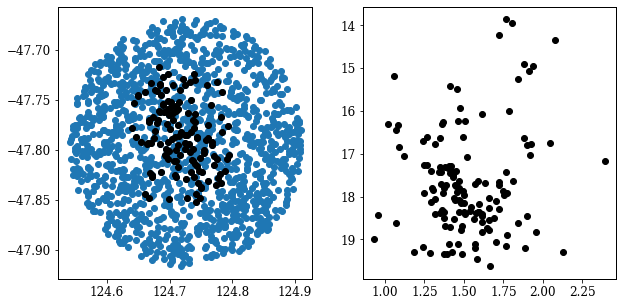

In [183]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(teste_final.ra,teste_final.dec, color = 'k', zorder = 100)
ax[0].scatter(ndf.ra,ndf.dec)


ax[1].scatter(teste_final['bp_rp'],teste_final['phot_g_mean_mag'], color = 'k')
ax[1].invert_yaxis()

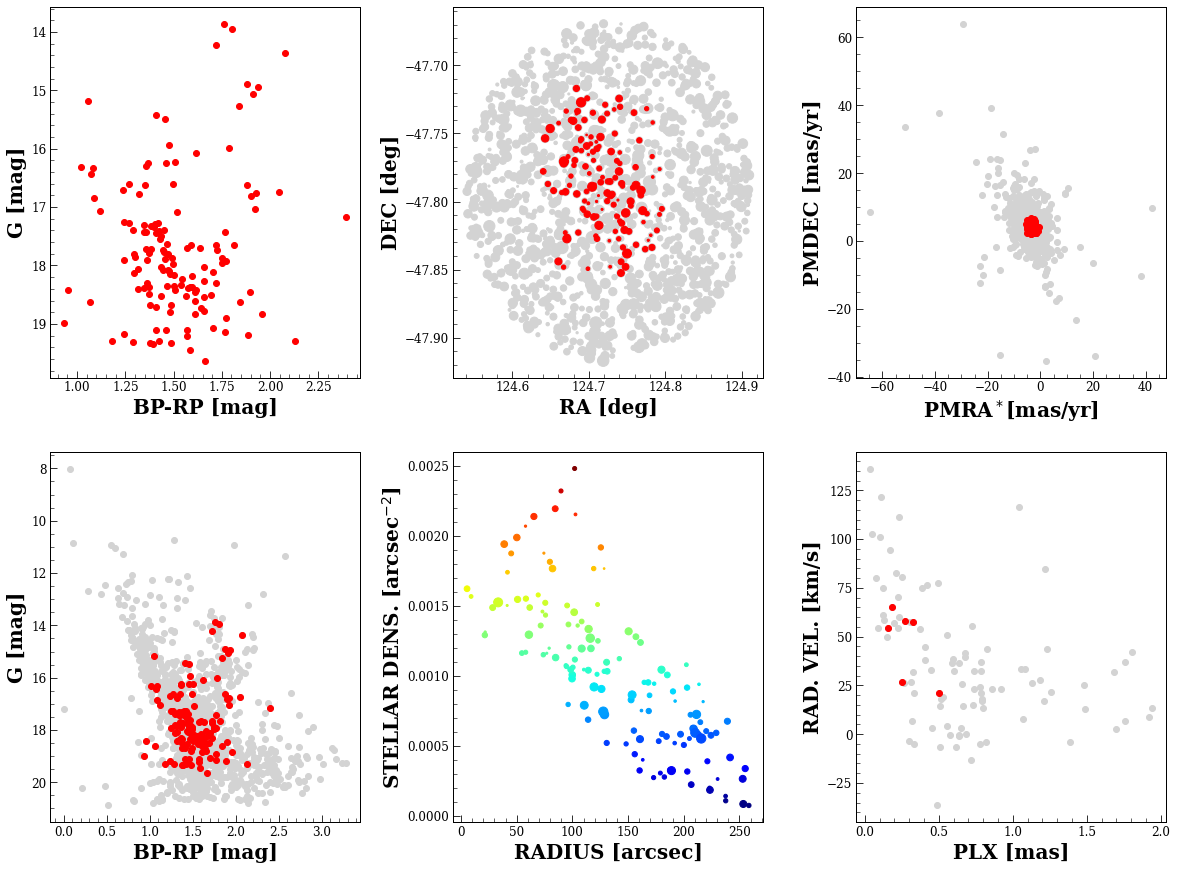

In [184]:
fig = plt.figure(figsize = (20,15))

ax1 = fig.add_subplot(2,3, (1,1))
ax2 = fig.add_subplot(2,3, (2,2))
ax3 = fig.add_subplot(2,3, (3,3))
ax4 = fig.add_subplot(2,3, (5,5))
ax5 = fig.add_subplot(2,3, (6,6))
ax6 = fig.add_subplot(2,3,(4,4))


clip_loop = teste_final 

ax6.scatter(clip_loop.bp_rp, clip_loop.phot_g_mean_mag, color = 'red', zorder = 100)
ax6.scatter(ndf.bp_rp, ndf.phot_g_mean_mag, color = 'lightgray')
ax6.invert_yaxis()
ax6.set_xlabel('BP-RP [mag]', fontweight = 'bold', fontsize = 20)
ax6.set_ylabel('G [mag]', fontweight = 'bold', fontsize = 20)

ax1.scatter(clip_loop.bp_rp, clip_loop.phot_g_mean_mag, color = 'red')
ax1.invert_yaxis()
ax1.set_xlabel('BP-RP [mag]', fontweight = 'bold', fontsize = 20)
ax1.set_ylabel('G [mag]', fontweight = 'bold', fontsize = 20)

ax2.scatter(clip_loop.ra, clip_loop.dec, color = 'red', s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*15, zorder = 1010)
ax2.scatter(ndf.ra, ndf.dec, color = 'lightgray', s=(max(ndf['phot_g_mean_mag'])-ndf['phot_g_mean_mag'])*15)
ax2.set_xlabel('RA [deg]', fontweight = 'bold', fontsize = 20)
ax2.set_ylabel('DEC [deg]', fontweight = 'bold', fontsize = 20)


ax3.scatter(clip_loop.pmra, clip_loop.pmdec, color = 'red', zorder= 100)
ax3.scatter(ndf.pmra, ndf.pmdec, color = 'lightgray')
ax3.set_xlabel('PMRA$^*$[mas/yr]', fontweight = 'bold', fontsize = 20)
ax3.set_ylabel('PMDEC [mas/yr]', fontweight = 'bold',fontsize = 20)


ra_vel_ndf = ndf.dropna(how='any',subset=['radial_velocity'])
ra_vel_ndf = ra_vel_ndf.loc[ra_vel_ndf.parallax <2]

ax5.scatter(ra_vel.parallax, ra_vel.radial_velocity, color = 'red', zorder= 100)
ax5.scatter(ra_vel_ndf.parallax, ra_vel_ndf.radial_velocity, color = 'lightgray')
ax5.set_xlabel('PLX [mas]', fontweight = 'bold',fontsize = 20)
ax5.set_ylabel('RAD. VEL. [km/s]', fontweight = 'bold',fontsize = 20)



radii, den_data = dens_profile(clip_loop)

import matplotlib.cm as cm
cor = cm.get_cmap('jet')


ax4.scatter(radii,den_data, s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*15, c=den_data/3600**2, cmap = cor)
ax4.set_xlabel('RADIUS [arcsec]', fontweight='bold', fontsize = 20)
ax4.set_ylabel('STELLAR DENS. [arcsec$^{-2}$]', fontweight='bold',fontsize = 20)


axs = [ax1,ax2,ax3,ax4,ax5,ax6]

for element in axs:
    element.xaxis.set_minor_locator(AutoMinorLocator())
    element.yaxis.set_minor_locator(AutoMinorLocator())
    element.tick_params(which = 'major', axis = 'y', direction='in', length = 7)
    element.tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
    element.tick_params(which = 'major', axis = 'x', direction='in', length = 7)
    element.tick_params(which = 'minor', axis = 'x', direction='in', length = 4)
    
plt.subplots_adjust(wspace = 0.3)
plt.show()



In [180]:
teste_final.to_csv('membros/raio_phasespace.csv', index = False)